# 1. Setup

In [ ]:
import sys
from pathlib import Path

# import gc

In [ ]:
# Horizontal Scrolling
import io
import base64
from IPython.display import HTML, display

In [ ]:
import datetime
import copy

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as MAE

In [ ]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [ ]:
PROJECT_ROOT = Path().resolve().parent
RAW_DATA_PATH = "../data/raw_data/"
ADDITIONAL_DATA_PATH = "../data/additional_data/"
PARQUET_DATA_PATH = "../data/parquet_data/"
sys.path.append(str(Path().resolve().parent))

In [ ]:
from utils.loading import load_raw_data, load_parquet_data

# from utils.preprocessing import process_all_dfs
# from utils.merging import merge_all_dfs
from utils.feature_engineering import (
    #     add_dst_flag,
    #     add_cyclic_datetime_features,
    #     get_lag,
    #     get_moving_average,
    get_month_splits,
)

In [ ]:
from utils.data_pipeline import DataPipeline

In [ ]:
pd.set_option(
    "display.float_format",
    lambda x: f"{x:.2e}" if abs(x) < 0.01 and x != 0 else f"{x:.2f}",
    "display.max_rows",
    100,
    "display.max_columns",
    100,
)
sns.set_style("whitegrid")

In [ ]:
CATEGORICAL_F = ["county", "product_type", "is_business", "is_consumption"]
RECORD_FEATURES = CATEGORICAL_F + ["datetime"]
RAND = 10

# 2. Data Preparation

In [ ]:
dp = DataPipeline(PARQUET_DATA_PATH)
dp.load()
dp.prepare()
dp.merge()

/app/pet_project/utils/data_pipeline.py:422: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna({column: False for column in holidays_names})


In [ ]:
LAG_SPECS = {
    "2d": {
        "3h": ["mean", "count"],
        "6h": ["mean", "count"],
        "24h": ["mean", "median", "std", "count"],
    },
    "3d": {
        "6h": ["mean", "count"],
        "12h": ["mean", "median", "count"],
    },
    "7d": {
        "12h": ["mean", "count"],
        "24h": ["mean", "median", "std", "count"],
    },
}

In [ ]:
dp.add_features(LAG_SPECS, CATEGORICAL_F, "datetime", "target")

In [ ]:
df = dp.df

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017824 entries, 0 to 2017823
Data columns (total 81 columns):
 #   Column                                Dtype         
---  ------                                -----         
 0   county                                category      
 1   product_type                          category      
 2   is_business                           bool          
 3   is_consumption                        bool          
 4   datetime                              datetime64[ns]
 5   target                                float32       
 6   eic_count                             float32       
 7   installed_capacity                    float32       
 8   lowest_price_per_mwh                  float32       
 9   highest_price_per_mwh                 float32       
 10  euros_per_mwh                         float32       
 11  f1_temperature                        float32       
 12  f1_dewpoint                           float32       
 13  f1_snowfall_

# 3. Baseline Comparison

## Train-Test Splits

In [ ]:
start_ts = df["datetime"].min()
print(
    f"First timestamp: {start_ts}",
    f"Last timestamp: {df['datetime'].max()}",
    sep="\n",
)

First timestamp: 2021-09-01 00:00:00
Last timestamp: 2023-05-31 23:00:00


In [ ]:
splits = get_month_splits(start_ts, 17, 2, 1, 3)
# splits = get_month_splits(start_ts, 17, 1, 1, 2)
splits

[{'train': (Timestamp('2021-09-01 00:00:00'),
   Timestamp('2023-01-31 23:00:00')),
  'test': (Timestamp('2023-02-01 00:00:00'),
   Timestamp('2023-03-31 23:00:00'))},
 {'train': (Timestamp('2021-09-01 00:00:00'),
   Timestamp('2023-02-28 23:00:00')),
  'test': (Timestamp('2023-03-01 00:00:00'),
   Timestamp('2023-04-30 23:00:00'))},
 {'train': (Timestamp('2021-09-01 00:00:00'),
   Timestamp('2023-03-31 23:00:00')),
  'test': (Timestamp('2023-04-01 00:00:00'),
   Timestamp('2023-05-31 23:00:00'))}]

## Model Training

In [ ]:
FEATURES_TO_DROP = ["datetime", "target"]

In [ ]:
cat_cols = df.select_dtypes(include=["bool", "category"]).columns.to_list()
cat_cols

['county',
 'product_type',
 'is_business',
 'is_consumption',
 'national_holiday',
 'observance_day',
 'season_event',
 'dst']

In [ ]:
scores = []
(
    xgb_mae_history,
    lgbm_mae_history,
    cb_mae_history,
    naive_mae,
) = (
    [],
    [],
    [],
    [],
)

xgb_p = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 7,
    "random_state": RAND,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "reg:absoluteerror",
    "enable_categorical": True,
    "eval_metric": "mae",
    "n_jobs": -1,
}
lgbm_p = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 7,
    "random_state": RAND,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "regression_l1",
    "metric": "mae",
    "n_jobs": -1,
    "force_col_wise": True,
    "verbosity": -1,
}
cb_p = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 7,
    "random_state": RAND,
    "subsample": 0.8,
    "colsample_bylevel": 0.8,
    "loss_function": "MAE",
    "cat_features": cat_cols,
    "eval_metric": "MAE",
    "thread_count": -1,
    "allow_writing_files": False,
    "verbose": False,
}

for i, split in enumerate(splits):

    train_mask = (df["datetime"] >= split["train"][0]) & (
        df["datetime"] <= split["train"][1]
    )
    X_train, y_train = (
        df.loc[
            train_mask,
            df.columns.difference(FEATURES_TO_DROP, sort=False),
        ],
        df.loc[train_mask, "target"],
    )

    test_mask = (df["datetime"] >= split["test"][0]) & (
        df["datetime"] <= split["test"][1]
    )
    X_test, y_test = (
        df.loc[
            test_mask,
            df.columns.difference(FEATURES_TO_DROP, sort=False),
        ],
        df.loc[test_mask, "target"],
    )

    eval_idx = X_train.sample(100_000, random_state=RAND).index
    eval_set = [(X_train.loc[eval_idx], y_train.loc[eval_idx])]

    for model_name, model_cls, model_params in [
        ("XGB", XGBRegressor, xgb_p),
        ("LGBM", LGBMRegressor, lgbm_p),
        ("CB", CatBoostRegressor, cb_p),
    ]:
        model = model_cls(**model_params)

        if isinstance(model, XGBRegressor):
            model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                verbose=0,
            )
            xgb_mae_history.append(model.evals_result())

        elif isinstance(model, LGBMRegressor):
            model.fit(
                X_train,
                y_train,
                categorical_feature=cat_cols,
                eval_set=eval_set,
            )
            lgbm_mae_history.append(model.evals_result_)

        else:
            model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                cat_features=cat_cols,
            )
            cb_mae_history.append(model.evals_result_)

        scores.append(
            {
                "Split": i,
                "Model": model_name,
                "MAE": MAE(y_test, model.predict(X_test)),
            }
        )
        # del model
        # gc.collect()

    # Naive baseline
    scores.append(
        {
            "Split": i,
            "Model": "Naive",
            "MAE": MAE(
                y_test.loc[X_test["target_lag_2d"].notna()],
                X_test["target_lag_2d"].dropna(),
            ),
        }
    )

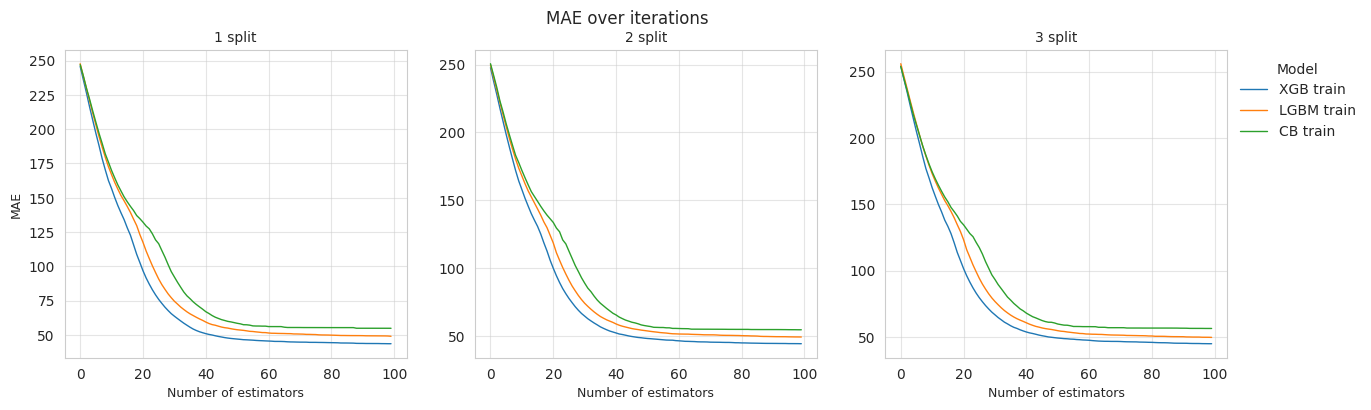

In [ ]:
total_splits = len(splits)
rows, cols = 1, total_splits
fig, axs = plt.subplots(rows, cols, figsize=(15, 4))
axs = axs.flatten()

for split_i in range(total_splits):
    ax = axs[split_i]
    ax.plot(
        xgb_mae_history[split_i]["validation_0"]["mae"],
        "C0",
        label=f"XGB train",
        lw=1,
    )
    ax.plot(
        # lgbm_mae_history[split_i]["training"]["l1"],
        lgbm_mae_history[split_i]["valid_0"]["l1"],
        "C1",
        label=f"LGBM train",
        lw=1,
    )
    ax.plot(
        cb_mae_history[split_i]["learn"]["MAE"],
        "C2",
        label=f"CB train",
        lw=1,
    )

    if split_i >= total_splits - cols:
        ax.set_xlabel("Number of estimators", size=9)
    if split_i in [i * cols for i in range(rows)]:
        ax.set_ylabel("MAE", size=9)
    ax.set_title(f"{split_i + 1} split", size=10)
    ax.grid(which="both", alpha=0.5)

plt.legend(
    title="Model",
    loc="upper left",
    bbox_to_anchor=(1, 1),
    frameon=False,
)
fig.suptitle(
    "MAE over iterations",
    # y=1.0125,
    fontsize=12,
)
plt.show()

In [ ]:
scores_df = pd.DataFrame(scores)
scores_df

,Split,Model,MAE
0,0,XGB,57.25
1,0,LGBM,59.93
2,0,CB,68.23
3,0,Naive,88.11
4,1,XGB,76.85
5,1,LGBM,80.66
6,1,CB,85.91
7,1,Naive,112.92
8,2,XGB,88.67
9,2,LGBM,91.90


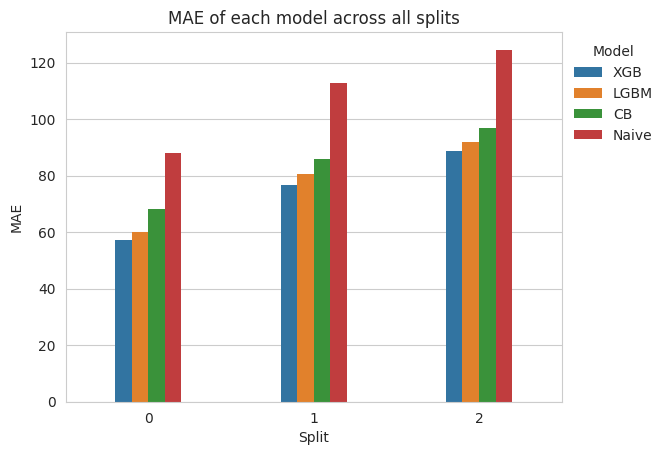

In [ ]:
sns.barplot(
    data=scores_df,
    x="Split",
    y="MAE",
    hue="Model",
    width=0.4,
    linewidth=0,
)
plt.title("MAE of each model across all splits")
plt.legend(
    title="Model",
    loc="upper left",
    bbox_to_anchor=(1, 1),
    frameon=False,
)
plt.show()

The XGBoost baseline shows the best results while the LightGBM baseline performs slightly worse. The gap with the CatBoost baseline is more significant, and XGBoost clearly outperforms the naive baseline.

## Separate Models for Consumption and Production

In the first notebook, it was verified that for each combination of `datetime`, `county`, `product_type`, and `is_business`, there is exactly one consumption and one production value (i.e., no class imbalance in this regard). It was also shown that while there are some similarities between the two target types, there are also notable differences. Therefore, it may be beneficial to train separate models for each target type.

In [ ]:
separate_pc_scores = []

for i, split in enumerate(splits):
    for is_cons in [False, True]:

        train_mask = (
            (df["datetime"] >= split["train"][0])
            & (df["datetime"] <= split["train"][1])
            & (df["is_consumption"] == is_cons)
        )
        X_train, y_train = (
            df.loc[
                train_mask,
                df.columns.difference(FEATURES_TO_DROP, sort=False),
            ],
            df.loc[train_mask, "target"],
        )

        test_mask = (
            (df["datetime"] >= split["test"][0])
            & (df["datetime"] <= split["test"][1])
            & (df["is_consumption"] == is_cons)
        )
        X_test, y_test = (
            df.loc[
                test_mask,
                df.columns.difference(FEATURES_TO_DROP, sort=False),
            ],
            df.loc[test_mask, "target"],
        )

        for model_name, model_cls, model_params in [
            ("XGB", XGBRegressor, xgb_p),
            ("LGBM", LGBMRegressor, lgbm_p),
            ("CB", CatBoostRegressor, cb_p),
        ]:
            model = model_cls(**model_params)

            if isinstance(model, XGBRegressor):
                model.fit(
                    X_train,
                    y_train,
                    verbose=0,
                )
            elif isinstance(model, LGBMRegressor):
                model.fit(
                    X_train,
                    y_train,
                    categorical_feature=cat_cols,
                )
            else:
                model.fit(
                    X_train,
                    y_train,
                    cat_features=cat_cols,
                )

            separate_pc_scores.append(
                {
                    "Split": i,
                    "Consumption": is_cons,
                    "Model": model_name,
                    "MAE": MAE(y_test, model.predict(X_test)),
                }
            )
            # del model
            # gc.collect()

        # Naive baseline
        separate_pc_scores.append(
            {
                "Split": i,
                "Consumption": is_cons,
                "Model": "Naive",
                "MAE": MAE(
                    y_test.loc[X_test["target_lag_2d"].notna()],
                    X_test["target_lag_2d"].dropna(),
                ),
            }
        )

In [ ]:
separate_pc_scores_df = pd.DataFrame(separate_pc_scores)
separate_pc_scores_df

,Split,Consumption,Model,MAE
0,0,False,XGB,26.05
1,0,False,LGBM,26.55
2,0,False,CB,28.00
3,0,False,Naive,45.45
4,0,True,XGB,75.40
5,0,True,LGBM,79.38
6,0,True,CB,90.07
7,0,True,Naive,130.77
8,1,False,XGB,59.73
9,1,False,LGBM,61.50


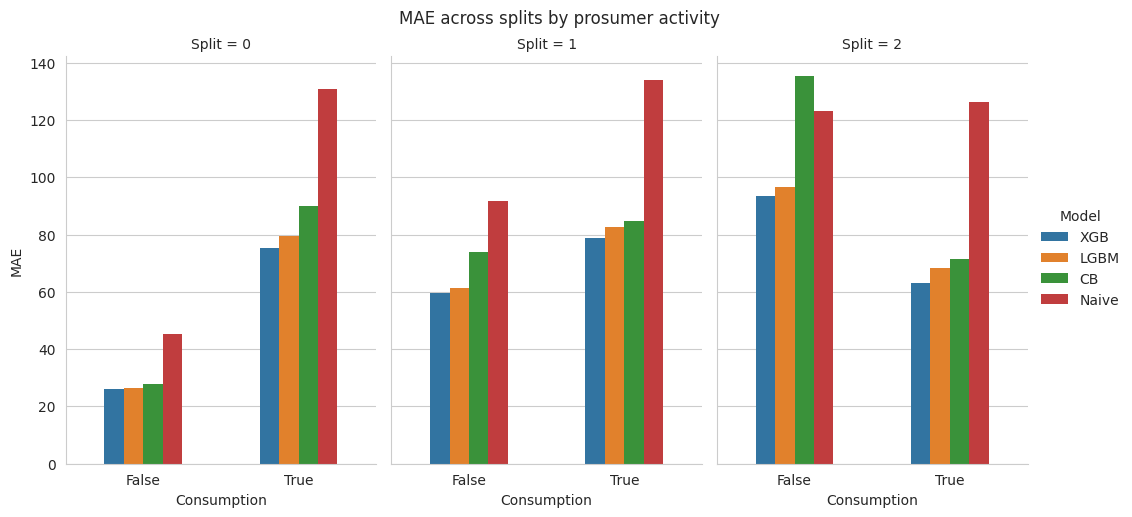

In [ ]:
sns.catplot(
    data=separate_pc_scores_df,
    x="Consumption",
    y="MAE",
    hue="Model",
    col="Split",
    kind="bar",
    width=0.5,
    linewidth=0,
    aspect=0.7,
).fig.suptitle("MAE across splits by prosumer activity", y=1.025)
plt.show()

In [ ]:
separate_pc_scores_df.groupby(["Model"], sort=False)[["MAE"]].mean()

,MAE
Model,
XGB,66.11
LGBM,69.18
CB,80.62
Naive,108.52


On average, the two-model approach achieves a lower monthly MAE compared to the single-model alternative.

## Fixed vs Expanding Splits

In [ ]:
# df.dtypes

In [ ]:
# df.isna().sum()